# Navigation

---

## Implementation detail

In my implementation, I basically use the from the deep Q network lesson and make some modification on it, such as Double DQN, Dueling DQN and prioritized experience replay. Next, I will briefly introduce the parts which are different from the original DQN implementation in previous lesson and compare the performance in final part.

### 1. Dueling Q Network

Different from original DQN network, Dueling Q network separately estimate the state value and the advantages for each actions, and then combine them into Q value. just as the image below(from [original paper](https://arxiv.org/abs/1511.06581)).

![Dueling network](./img/dueling.png)

#### Modification

In [ ]:
class DuelingQNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        super(DuelingQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.fc1 = nn.Linear(state_size, 64)
        self.fc_state1 = nn.Linear(64, 64)
        self.fc_state2 = nn.Linear(64, 1)
        self.fc_advantange1 = nn.Linear(64, 64)
        self.fc_advantange2 = nn.Linear(64, action_size)
        
        self.seed = torch.manual_seed(seed)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        state = F.relu(self.fc1(state))
        
        state_value = F.relu(self.fc_state1(state))
        state_value = self.fc_state2(state_value).expand(64, self.action_size)
        adv_value = F.relu(self.fc_advantange1(state))
        adv_value = self.fc_advantange2(adv_value)
        
        # sum up state value and action value minus mean of action value
        total_Q = state_value + adv_value - adv_value.mean(1).unsqueeze(1).expand(64, self.action_size)
        return total_Q

#### Original

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        self.seed = random.seed(seed)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 2. Double DQN

Instead of directly perform the best action from target Q network which usually cause the overestimating of the action value, Double DQN select the best action from local network first, then use the action in target network.

#### Modification

In [ ]:
# Double Q Learning
# Get the action indices which can produce maximum Q value in local Q network.
next_action_indice = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
# Perform these actions in Q target network.
Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, next_action_indice)

#### Original

In [ ]:
# Get max predicted Q values (for next states) from target model
Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

### 3. Prioritized Experience Replay

some experiences may be important and more useful to model than others, so **PER** is a method  which give the higher possibility for model to access these experiences not just random select some experiences from buffer, and it using TD-error to rank these experience.

This PrioritizedReplayBuffer is from https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
and have been modified in some parts.

#### modification

In [ ]:
class ReplayBuffer(object):
    """This ReplayBuffer base class is from 
        https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
        implemented by openai
    """
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        obses_t = torch.from_numpy(np.vstack(obses_t)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).float().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        obses_tp1 = torch.from_numpy(np.vstack(obses_tp1)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)
        return obses_t, actions, rewards, obses_tp1, dones

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

class PrioritizedReplayBuffer(ReplayBuffer):
    """This PrioritizedReplayBuffer buffer is from 
        https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
        and have been modified in some parts.
    """
    def __init__(self, size, alpha, beta, beta_increment, epsilon, seed=0):
        """Create Prioritized Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        alpha: float
            how much prioritization is used
            (0 - no prioritization, 1 - full prioritization)
        beta: float
            To what degree to use importance weights
            (0 - no corrections, 1 - full correction)
        beta_increment: float
            increase beta in every sample step until beta reach one
        epsilon: float
            A constant number add up with prioirty when updating
        See Also
        --------
        ReplayBuffer.__init__
        """
        super(PrioritizedReplayBuffer, self).__init__(size)
        assert alpha >= 0
        self._alpha = alpha
        self._epsilon = epsilon
        self._beta = beta
        self._beta_increment = beta_increment
        self.seed = seed
        
        it_capacity = 1
        while it_capacity < size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)
        self._max_priority = 1.0

    def add(self, *args, **kwargs):
        """See ReplayBuffer.store_effect"""
        idx = self._next_idx
        super().add(*args, **kwargs)
        self._it_sum[idx] = self._max_priority ** self._alpha
        self._it_min[idx] = self._max_priority ** self._alpha

    def _sample_proportional(self, batch_size):
        res = []
        p_total = self._it_sum.sum(0, len(self._storage) - 1)
        every_range_len = p_total / batch_size
        for i in range(batch_size):
            mass = random.random() * every_range_len + i * every_range_len
            idx = self._it_sum.find_prefixsum_idx(mass)
            res.append(idx)
        return res

    def sample(self, batch_size):
        """Sample a batch of experiences.
        compared to ReplayBuffer.sample
        it also returns importance weights and idxes
        of sampled experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        encoded_sample: tuple
            batch of (s, a, r, s', done) numpy arrays in tuple
        idxes: np.array
            Array of shape (batch_size,) and dtype np.int32
            idexes in buffer of sampled experiences
        weights: np.array
            Array of shape (batch_size,) and dtype np.float32
            denoting importance weight of each sampled transition
        """
        self._beta = np.min([1., self._beta + self._beta_increment])
        
        idxes = self._sample_proportional(batch_size)

        weights = []
        p_min = self._it_min.min() / self._it_sum.sum()
        max_weight = (p_min * len(self._storage)) ** (-self._beta)

        for idx in idxes:
            p_sample = self._it_sum[idx] / self._it_sum.sum()
            weight = (p_sample * len(self._storage)) ** (-self._beta)
            weights.append(weight / max_weight)
        weights = np.array(weights)
        encoded_sample = self._encode_sample(idxes)
        return (encoded_sample), idxes, weights

    def update_priorities(self, idxes, priorities):
        """Update priorities of sampled transitions.
        sets priority of transition at index idxes[i] in buffer
        to priorities[i].
        Parameters
        ----------
        idxes: [int]
            List of idxes of sampled transitions
        priorities: [float]
            List of updated priorities corresponding to
            transitions at the sampled idxes denoted by
            variable `idxes`.
        """
        assert len(idxes) == len(priorities)
        priorities += self._epsilon
        for idx, priority in zip(idxes, priorities):
            assert 0 <= idx < len(self._storage)
            self._it_sum[idx] = priority ** self._alpha
            self._it_min[idx] = priority ** self._alpha

            self._max_priority = max(self._max_priority, priority)

#### SumTree

Sumtree is a kind of tree data structure, which the value of parent node is the sum of the children' node.

In [ ]:
class SegmentTree(object):
    def __init__(self, capacity, operation, neutral_element):
        """Build a Segment Tree data structure.
        https://en.wikipedia.org/wiki/Segment_tree
        Can be used as regular array, but with two
        important differences:
            a) setting item's value is slightly slower.
               It is O(lg capacity) instead of O(1).
            b) user has access to an efficient ( O(log segment size) )
               `reduce` operation which reduces `operation` over
               a contiguous subsequence of items in the array.
        Paramters
        ---------
        capacity: int
            Total size of the array - must be a power of two.
        operation: lambda obj, obj -> obj
            and operation for combining elements (eg. sum, max)
            must form a mathematical group together with the set of
            possible values for array elements (i.e. be associative)
        neutral_element: obj
            neutral element for the operation above. eg. float('-inf')
            for max and 0 for sum.
        """
        assert capacity > 0 and capacity & (capacity - 1) == 0, "capacity must be positive and a power of 2."
        self._capacity = capacity
        self._value = [neutral_element for _ in range(2 * capacity)]
        self._operation = operation

    def _reduce_helper(self, start, end, node, node_start, node_end):
        if start == node_start and end == node_end:
            return self._value[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._reduce_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self._operation(
                    self._reduce_helper(start, mid, 2 * node, node_start, mid),
                    self._reduce_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end)
                )

    def reduce(self, start=0, end=None):
        """Returns result of applying `self.operation`
        to a contiguous subsequence of the array.
            self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))
        Parameters
        ----------
        start: int
            beginning of the subsequence
        end: int
            end of the subsequences
        Returns
        -------
        reduced: obj
            result of reducing self.operation over the specified range of array elements.
        """
        if end is None:
            end = self._capacity
        if end < 0:
            end += self._capacity
        end -= 1
        return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

    def __setitem__(self, idx, val):
        # index of the leaf
        idx += self._capacity
        self._value[idx] = val
        idx //= 2
        while idx >= 1:
            self._value[idx] = self._operation(
                self._value[2 * idx],
                self._value[2 * idx + 1]
            )
            idx //= 2

    def __getitem__(self, idx):
        assert 0 <= idx < self._capacity
        return self._value[self._capacity + idx]


class SumSegmentTree(SegmentTree):
    def __init__(self, capacity):
        super(SumSegmentTree, self).__init__(
            capacity=capacity,
            operation=operator.add,
            neutral_element=0.0
        )

    def sum(self, start=0, end=None):
        """Returns arr[start] + ... + arr[end]"""
        return super(SumSegmentTree, self).reduce(start, end)

    def find_prefixsum_idx(self, prefixsum):
        """Find the highest index `i` in the array such that
            sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum
        if array values are probabilities, this function
        allows to sample indexes according to the discrete
        probability efficiently.
        Parameters
        ----------
        perfixsum: float
            upperbound on the sum of array prefix
        Returns
        -------
        idx: int
            highest index satisfying the prefixsum constraint
        """
        assert 0 <= prefixsum <= self.sum() + 1e-5
        idx = 1
        while idx < self._capacity:  # while non-leaf
            if self._value[2 * idx] > prefixsum:
                idx = 2 * idx
            else:
                prefixsum -= self._value[2 * idx]
                idx = 2 * idx + 1
        return idx - self._capacity

#### update TD-Error

In [ ]:
# Compute TD-error
errors = torch.abs(Q_expected - Q_targets).data.cpu().numpy()

# update memory priority
self.memory.update_priorities(idxs, errors)

# Weighted MSE Loss function
loss = (torch.from_numpy(is_weights).cpu().float() * ((Q_expected-Q_targets).cpu() ** 2)).mean()

#### Original

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Hyper parameters

I use this set of hyper parameters, there may exist other set of parameter could perform better than this one

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size

GAMMA = 0.99            # discount factor
ALPHA = 0.6             # how much prioritization is used
BETA = 0.4              # initial value of beta for prioritized replay buffer
BETA_INCREMENT_PER_STEP = 0.001 # number of iterations over which beta will be annealed from initial value
EPSILON = 0.01          # epsilon to add to the TD errors when updating priorities.
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

## Performance Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
origin_record = pd.read_csv('../record/origin.csv')
modified_record = pd.read_csv('../record/combine.csv')

In [6]:
modified_record.head()

,Combine
0,0.0
1,2.0
2,0.0
3,0.0
4,-1.0


In [13]:
origin_solved_episode = origin_record[origin_record.rolling(100).mean() >= 13.0].dropna().index[0]
modified_solved_episode = modified_record[modified_record.rolling(100).mean() >= 13.0].dropna().index[0]
print("Origin version solved at {} episode".format(origin_solved_episode))
print("Modified version solved at {} episode".format(modified_solved_episode))

Origin version solved at 532 episode
Modified version solved at 486 episode


#### Plot

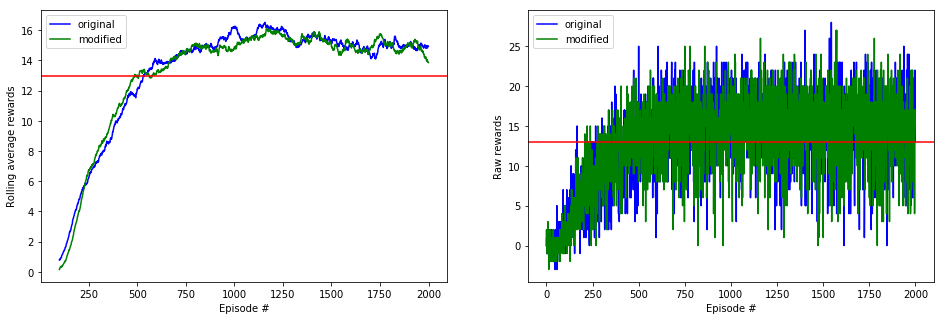

In [32]:
# plot the scores
fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(121)

l11 = plt.plot(np.arange(len(origin_record)), origin_record.rolling(100).mean(), 'b-', label='original')
l12 = plt.plot(np.arange(len(modified_record)), modified_record.rolling(100).mean(), 'g-', label='modified')
plt.legend()
plt.axhline(y=13.0, color='r', linestyle='-')
plt.ylabel('Rolling average rewards')
plt.xlabel('Episode #')

ay = fig.add_subplot(122)
l21 = plt.plot(np.arange(len(origin_record)), origin_record, 'b-', label='original')
l22 = plt.plot(np.arange(len(modified_record)), modified_record, 'g-', label='modified')
plt.legend()
plt.axhline(y=13.0, color='r', linestyle='-')
plt.ylabel('Raw rewards')
plt.xlabel('Episode #')
plt.show()

### Conclusion

we can see that the modified version is very slightly better than the original one. it solved this problem(the red horizontal line) faster than original one. Although it did not perform better in later episodes. 

### Future work

There are several ways may improve the performance of model. First, add more methods such as A3C, Noisy DQN or implement Rainbow DQN, these methods have already show better result in other problem and maybe as well as in this problem. Second, tune the hyper parameters, I did not try many combination of parameters, so other set may perform well. Final, adjust the Q network architecture could also perform better, just like tunning the hyper parameter.